# Synthesis planning

### Full-route reranking.

In [2]:
import pandas as pd

import wandb

api = wandb.Api()

# Project is specified by <entity/project-name>
runs = api.runs("liac/steer-test")

summary_list, config_list, name_list = [], [], []
for run in runs:
    if int(run.name.split('-')[-1]) < 234:
        continue
    # .summary contains the output keys/values for metrics like accuracy.
    #  We call ._json_dict to omit large files 
    summary_list.append(pd.Series(run.summary._json_dict))

    # .config contains the hyperparameters.
    #  We remove special values that start with _.
    config_list.append(
        pd.Series({k: v for k,v in run.config.items()
          if not k.startswith('_')}))

    # .name is the human-readable name of the run.
    name_list.append(run.name)


df_summ = pd.concat(summary_list, axis=1)
df_conf = pd.concat(config_list, axis=1)

df = pd.concat([df_summ, df_conf]).T

In [3]:
from steer.evaluation.synthesis import load_default_tasks

tasks = load_default_tasks()

smi = {}
for t in tasks:
    smi[t.id] = t.smiles

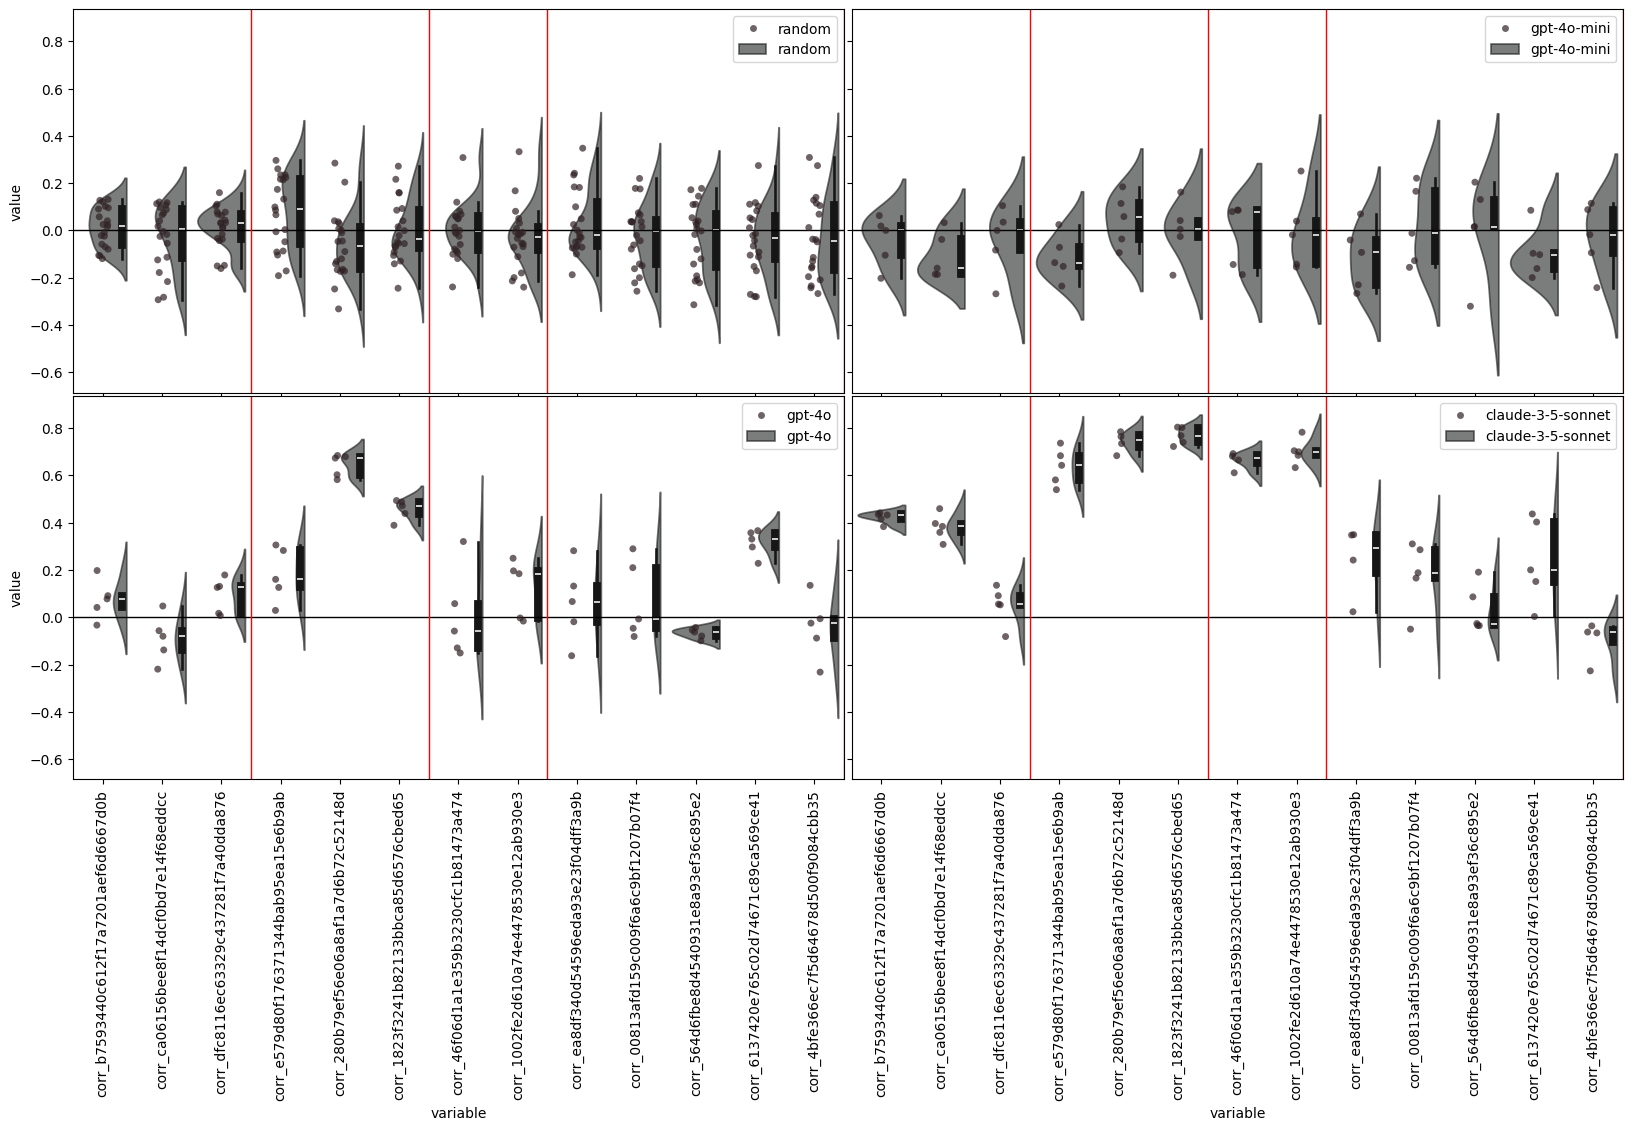

In [63]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

corr_cols = df.columns[df.columns.str.startswith('corr')]


def plot_corrs(model, ax):
    # Select the random, and see what's going on with some tasks with high variation
    gr = df[['model', *corr_cols]].sort_values('model')

    data = gr[gr['model'] == model].melt(id_vars='model').replace('NaN', np.nan)
    data.dropna(inplace=True)
    data['smiles'] = data['variable'].apply(lambda x: len(smi[x.split('_')[1]]))
    data.sort_values('smiles', inplace=True)

    sns.stripplot(data=data, x='variable', y='value', hue='model',  ax=ax, jitter=True, palette='dark:pink', alpha=0.7)
    sns.violinplot(data=data, x='variable', y='value', hue='model', ax=ax, palette='dark:cyan', split=True, alpha=0.6)


fig, ax = plt.subplots(2,2,figsize=(20, 10), gridspec_kw={'wspace': 0.01, 'hspace':0.01}, sharey=True, sharex=True)
ax = ax.ravel()
models = ['random', 'gpt-4o-mini', 'gpt-4o', 'claude-3-5-sonnet']
for i, x in enumerate(ax):
    plot_corrs(models[i], x)

    x.legend(loc=1)

    for tick in x.get_xticklabels():
        tick.set_rotation(90)
    x.axhline(0, color='black', lw=1)

    cum = -0.5
    for j in [3,3,2,5]:
        cum += j
        x.axvline(cum, color='red', lw=1)

plt.show()

In [58]:
tasks_order = [x.get_text().split('_')[1] for x in ax[2].get_xticklabels()]
tasks_order

['b7593440c612f17a7201aef6d6667d0b',
 'ca06156bee8f14dcf0bd7e14f68eddcc',
 'dfc8116ec63329c437281f7a40dda876',
 'e579d80f176371344bab95ea15e6b9ab',
 '280b79ef56e06a8af1a7d6b72c52148d',
 '1823f3241b82133bbca85d6576cbed65',
 '46f06d1a1e359b3230cfc1b81473a474',
 '1002fe2d610a74e4478530e12ab930e3',
 'ea8df340d54596eda93e23f04dff3a9b',
 '00813afd159c009f6a6c9bf1207b07f4',
 '564d6fbe8d4540931e8a93ef36c895e2',
 '6137420e765c02d74671c89ca569ce41',
 '4bfe366ec7f5d64678d500f9084cbb35']

In [59]:
# Plot LM scores vs route size

# Each entry in df has a distribution. Get all those points

import json
import os


def _route_size(rt):
    rt = str(rt)
    return rt.count("'type': 'reaction'")


def get_scores_len(data):
    scores = [d['lmdata']['routescore'] for d in data]
    sizes = [_route_size(d) for d in data]
    return scores, sizes


def distrib_from_file(row):
    dirp = row['results_dir']
    path = os.path.join('..', dirp)

    results = {}
    for fname in os.listdir(path):
        with open(os.path.join(path, fname), 'r') as f:
            sc, rt_len = get_scores_len(json.load(f))
            results[fname.split('.')[0]] = {
                "scores": sc,
                "rt_len": rt_len
            }
    return results


all_results = {}
for i in range(len(df)):
    all_results[i] = distrib_from_file(df.iloc[i])

/tmp/ipykernel_3410823/1242296203.py:8: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(x=rt_lens, y=scs, ax=ax[idx])


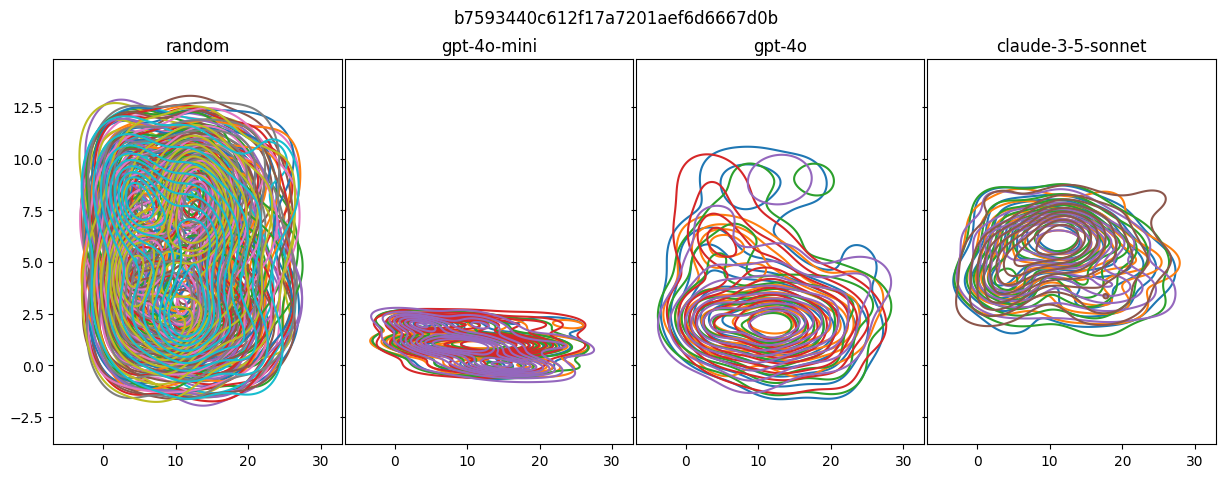

/tmp/ipykernel_3410823/1242296203.py:8: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(x=rt_lens, y=scs, ax=ax[idx])


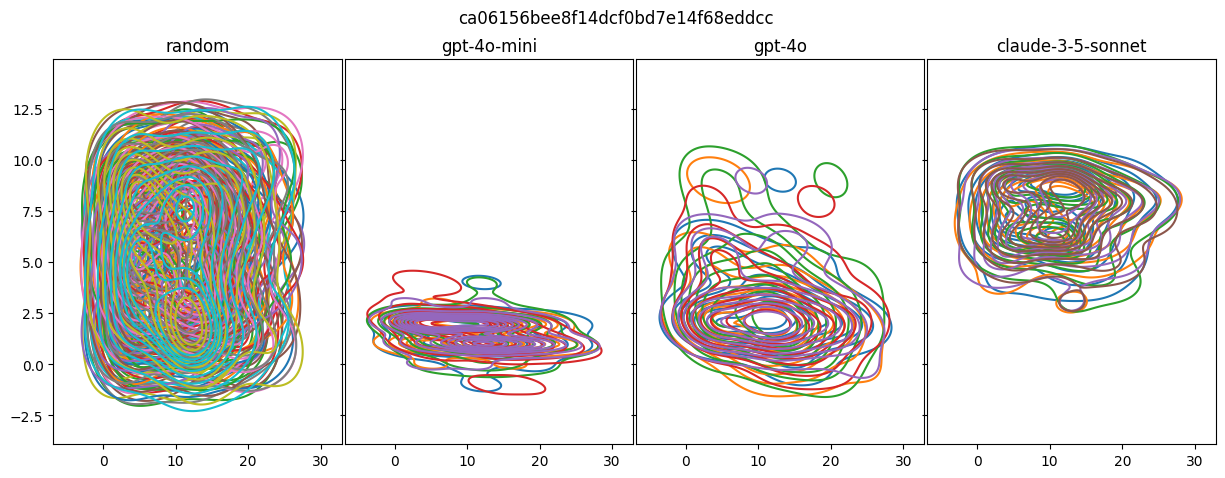

/tmp/ipykernel_3410823/1242296203.py:8: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(x=rt_lens, y=scs, ax=ax[idx])


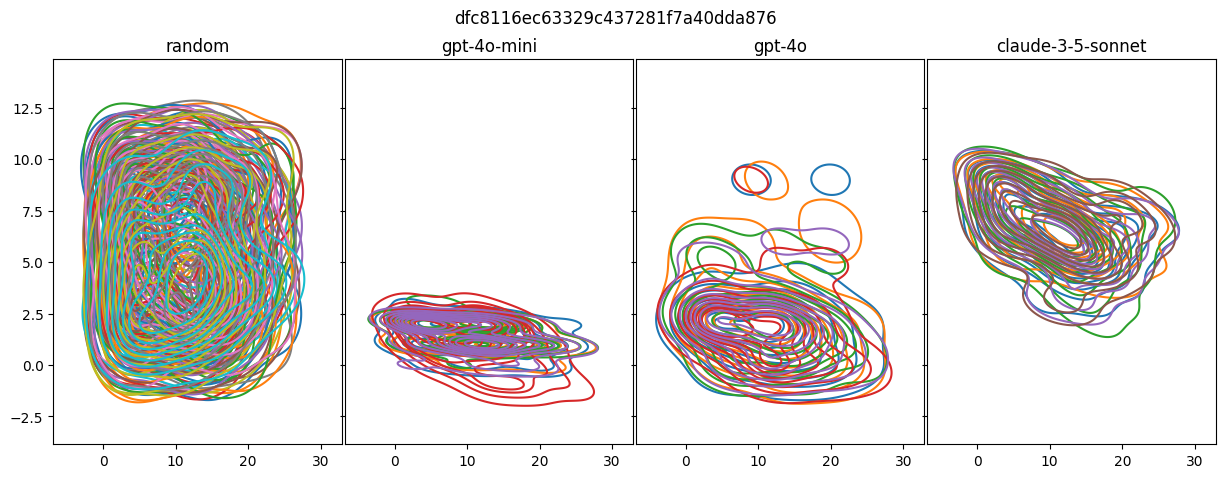

/tmp/ipykernel_3410823/1242296203.py:8: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(x=rt_lens, y=scs, ax=ax[idx])


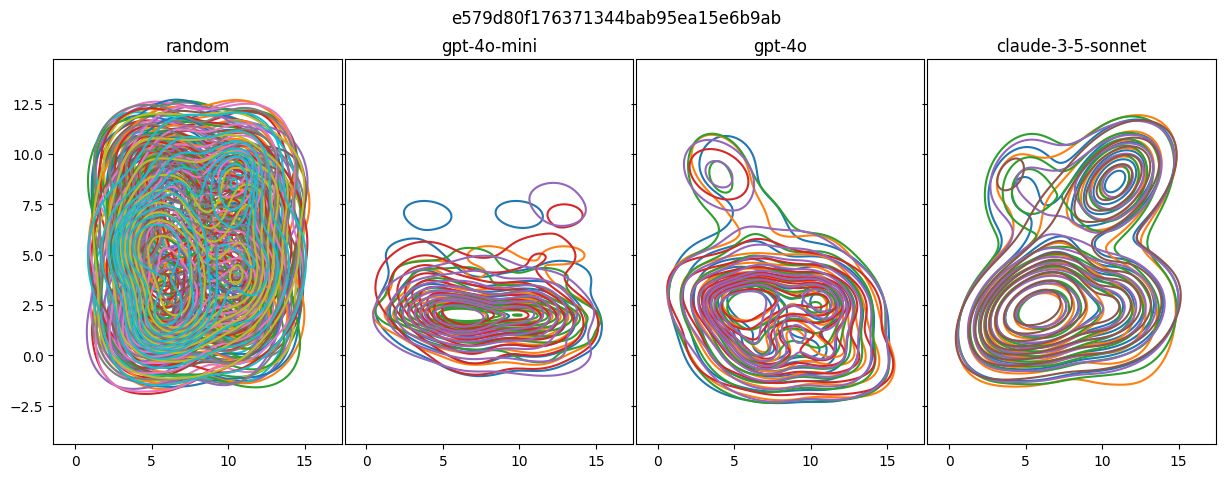

/tmp/ipykernel_3410823/1242296203.py:8: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(x=rt_lens, y=scs, ax=ax[idx])
/tmp/ipykernel_3410823/1242296203.py:8: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(x=rt_lens, y=scs, ax=ax[idx])


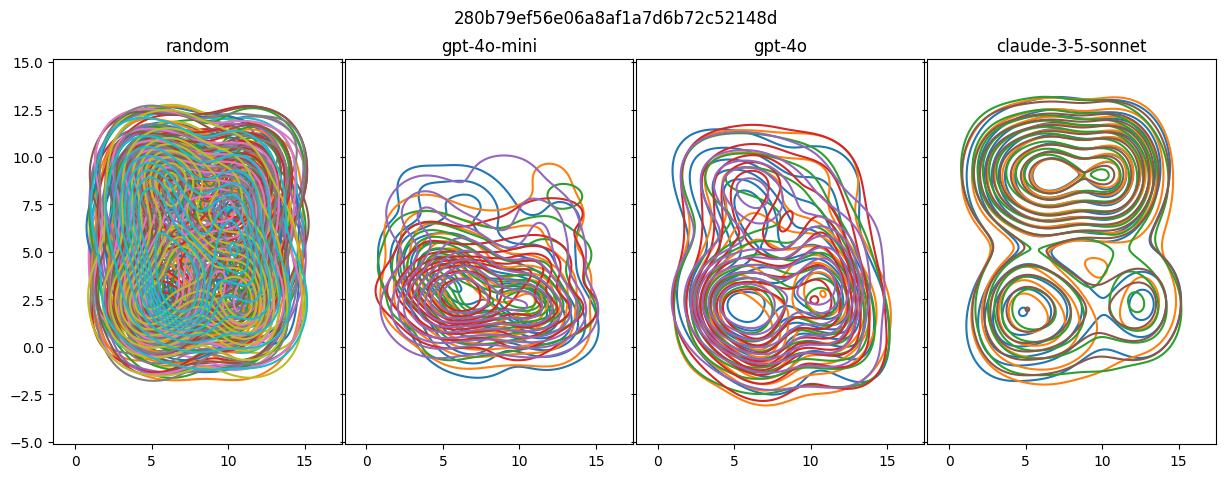

/tmp/ipykernel_3410823/1242296203.py:8: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(x=rt_lens, y=scs, ax=ax[idx])


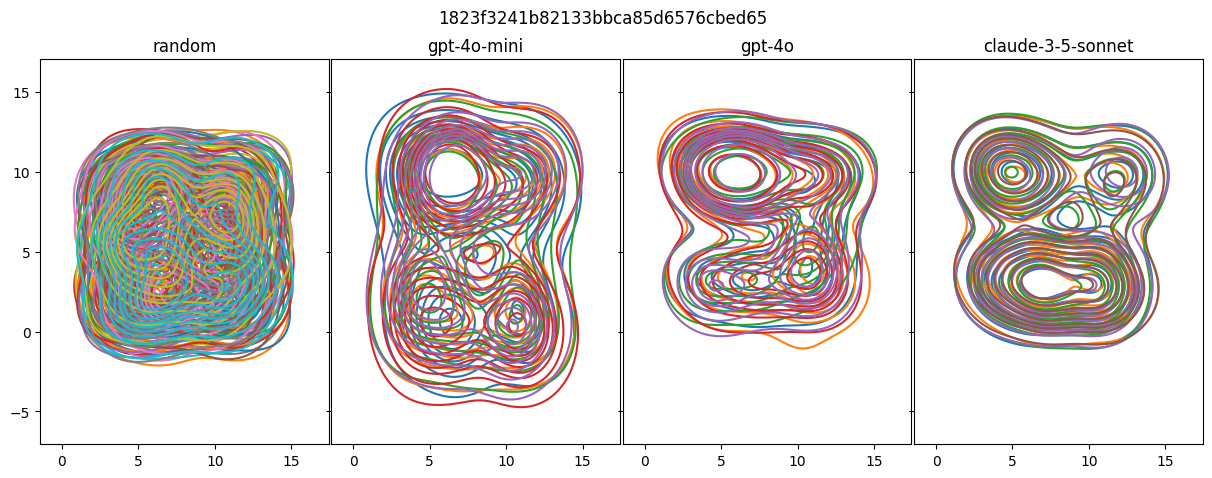

/tmp/ipykernel_3410823/1242296203.py:8: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(x=rt_lens, y=scs, ax=ax[idx])
/tmp/ipykernel_3410823/1242296203.py:8: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(x=rt_lens, y=scs, ax=ax[idx])


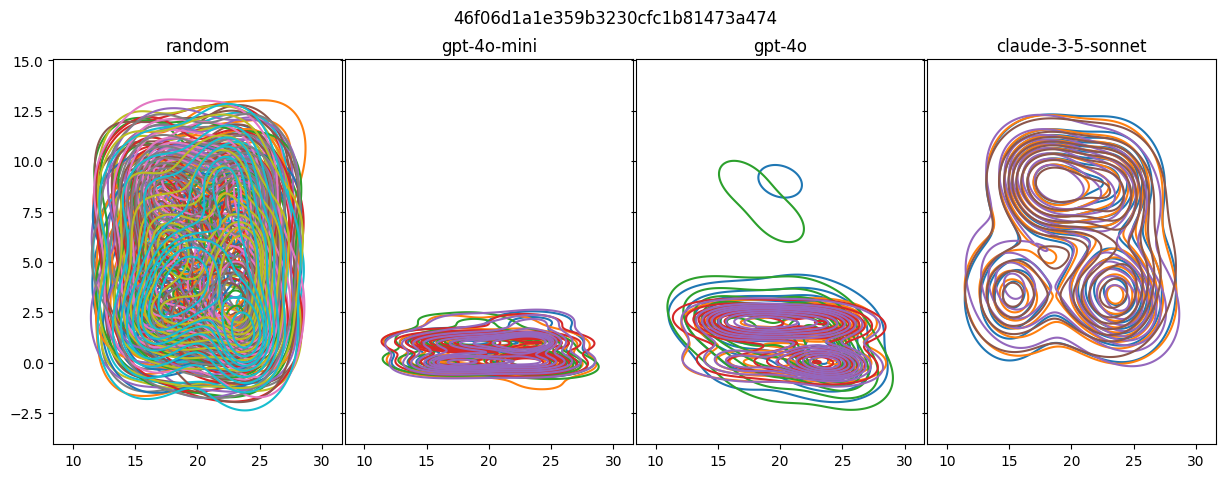

/tmp/ipykernel_3410823/1242296203.py:8: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(x=rt_lens, y=scs, ax=ax[idx])


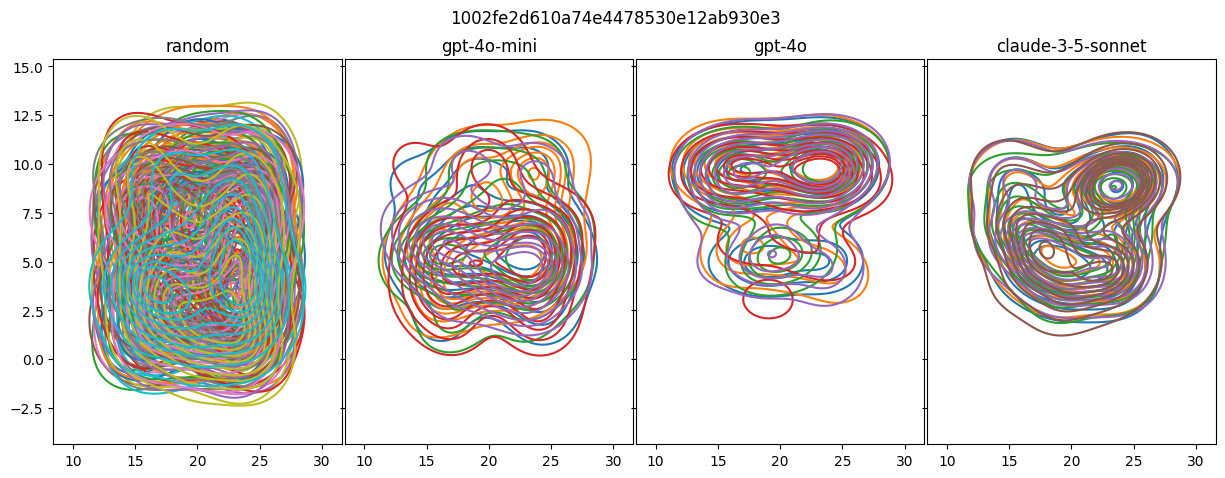

/tmp/ipykernel_3410823/1242296203.py:8: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(x=rt_lens, y=scs, ax=ax[idx])
/tmp/ipykernel_3410823/1242296203.py:8: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(x=rt_lens, y=scs, ax=ax[idx])


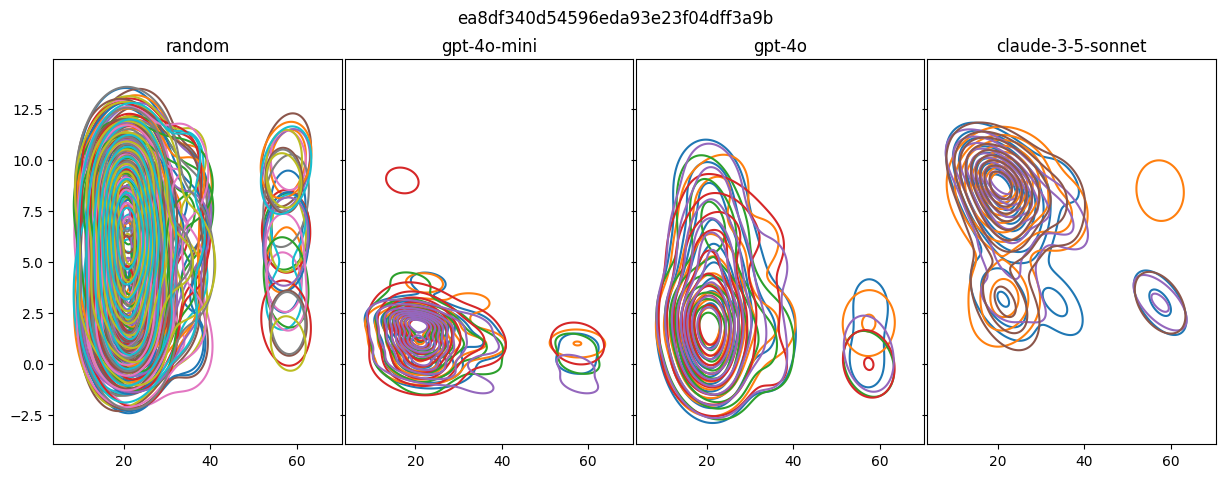

/tmp/ipykernel_3410823/1242296203.py:8: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(x=rt_lens, y=scs, ax=ax[idx])


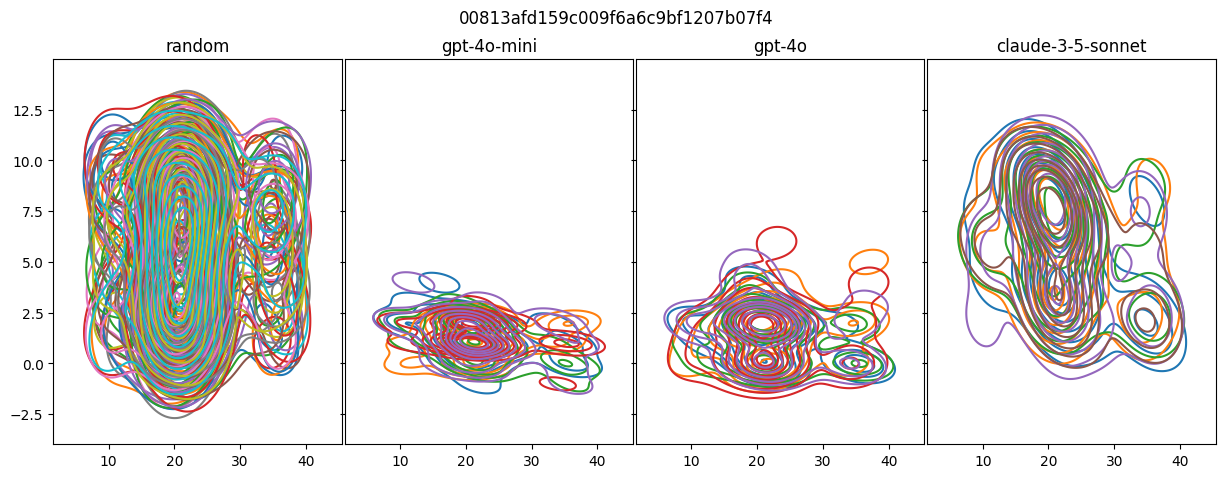

/tmp/ipykernel_3410823/1242296203.py:8: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(x=rt_lens, y=scs, ax=ax[idx])


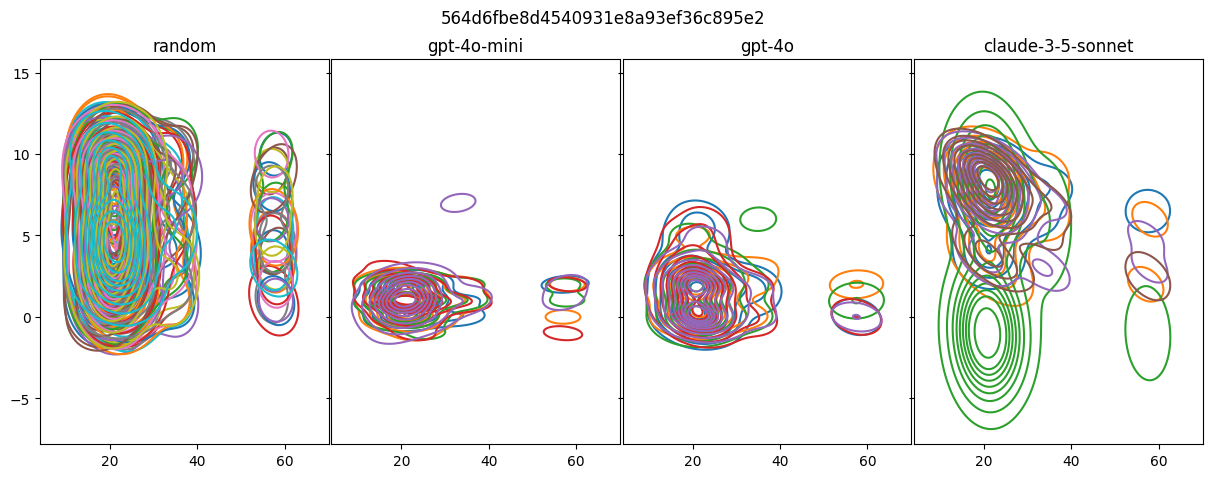

/tmp/ipykernel_3410823/1242296203.py:8: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(x=rt_lens, y=scs, ax=ax[idx])


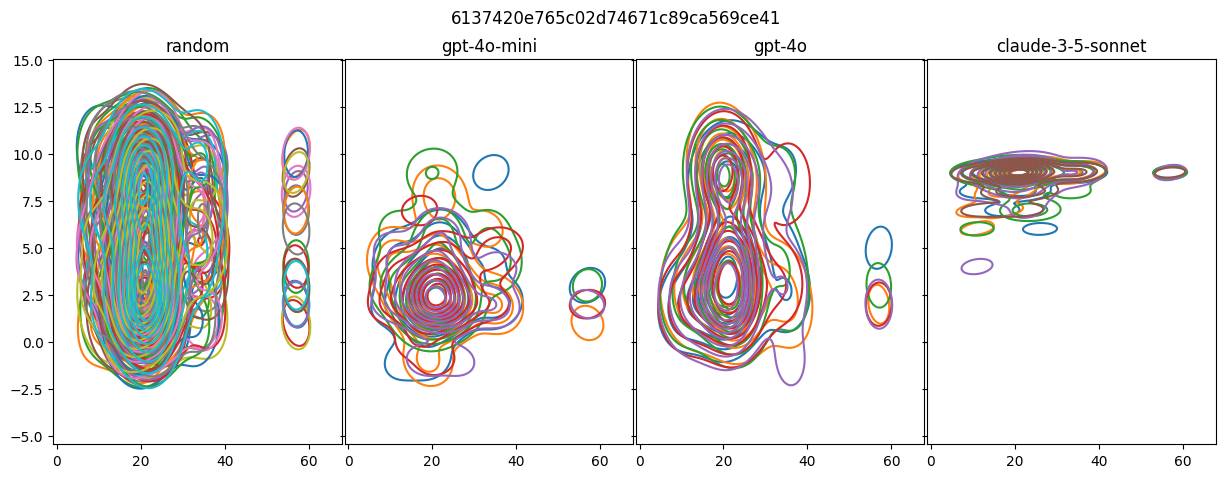

/tmp/ipykernel_3410823/1242296203.py:8: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(x=rt_lens, y=scs, ax=ax[idx])
/tmp/ipykernel_3410823/1242296203.py:8: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(x=rt_lens, y=scs, ax=ax[idx])


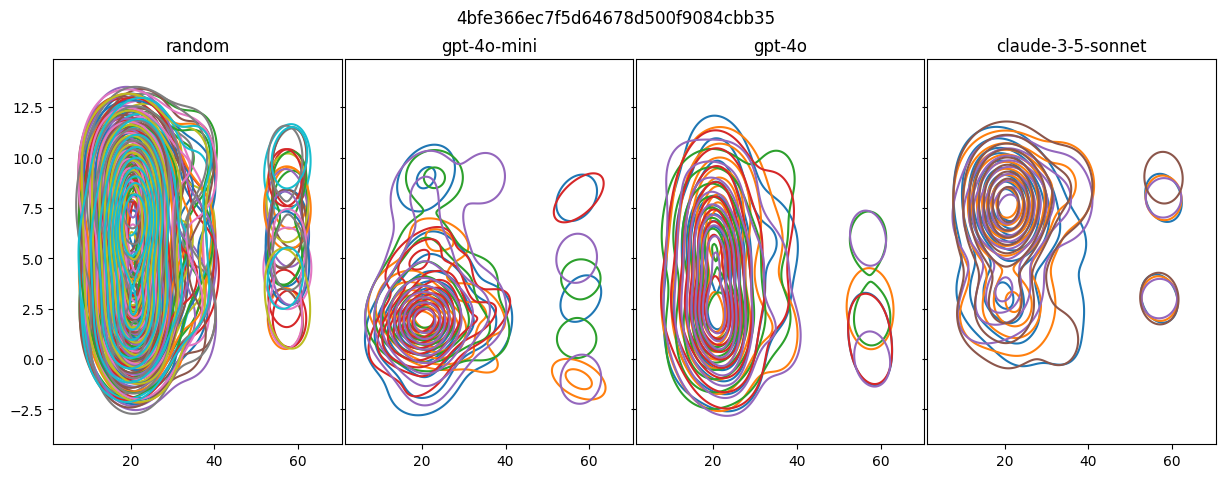

In [65]:
for task in tasks_order:
    fig, ax = plt.subplots(1,4,figsize=(15, 5), sharey=True, gridspec_kw={'wspace': 0.01, 'hspace':0.01})
    models = ['random', 'gpt-4o-mini', 'gpt-4o', 'claude-3-5-sonnet']
    results = {}
    for k, v in all_results.items():
        scs, rt_lens = v[task]['scores'], v[task]['rt_len']
        idx = models.index(df.iloc[k]['model'])
        sns.kdeplot(x=rt_lens, y=scs, ax=ax[idx])
        ax[idx].set_title(df.iloc[k]['model'])
    fig.suptitle(task)
    plt.show()

# Mechanism generation

### Single-step selection

In [48]:
from openai import OpenAI

client = OpenAI(
  base_url="https://openrouter.ai/api/v1",
  api_key="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",
)

completion = client.chat.completions.create(
  extra_headers={
    "HTTP-Referer": "<YOUR_SITE_URL>", # Optional. Site URL for rankings on openrouter.ai.
    "X-Title": "<YOUR_SITE_NAME>", # Optional. Site title for rankings on openrouter.ai.
  },
  model="deepseek/deepseek-chat",
  messages=[
    {
      "role": "user",
      "content": "What is the meaning of life?"
    }
  ]
)
print(completion.choices[0].message.content)

The meaning of life is a deeply philosophical and personal question that has been explored by thinkers, philosophers, and individuals throughout history. It does not have a single, definitive answer, as its meaning can vary depending on cultural, religious, philosophical, or individual perspectives. Here are a few ways people have approached this question:

1. **Existential Perspective**: Some existentialist philosophers, like Jean-Paul Sartre, argue that life has no inherent meaning, and it is up to individuals to create their own purpose through their choices and actions.

2. **Religious Perspective**: Many religions suggest that the meaning of life is tied to spiritual or divine purposes. For example, in Christianity, it might be about serving God and living a righteous life; in Buddhism, it might be about achieving enlightenment and understanding the nature of existence.

3. **Humanistic Perspective**: Humanists often believe that the meaning of life is to seek personal fulfillment